## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px;">Setup</p>

In [1]:
import os

if not os.path.isdir('src'):
    !git init .
    !git remote add origin https://github.com/Manuel-Materazzo/Blood-Glucose-Prediction.git

print('Pulling...')
!git pull origin master -q

print('Installing dependencies...')
!pip install -r /kaggle/working/src/requirements.txt -q

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from src.pipelines.dt_pipeline import DTPipeline
from src.pipelines.empty_dt_pipeline import EmptyDTPipeline
from src.preprocessors.empty_data_preprocessor import EmptyDataPreprocessor

from src.enums.accuracy_metric import AccuracyMetric
from src.enums.optimization_direction import OptimizationDirection

from src.models.catboost_regressor import CatBoostRegressorWrapper
from src.models.hgb_regressor import HGBRegressorWrapper
from src.models.lgbm_regressor import LGBMRegressorWrapper
from src.models.xgb_regressor import XGBRegressorWrapper
from src.models.tabnet_regressor import TabNetRegressorWrapper

from src.models.catboost_classifier import CatBoostClassifierWrapper
from src.models.hgb_classifier import HGBClassifierWrapper
from src.models.lgbm_classifier import LGBMClassifierWrapper
from src.models.xgb_classifier import XGBClassifierWrapper
from src.models.tabnet_classifier import TabNetClassifierWrapper

from src.trainers.simple_trainer import SimpleTrainer
from src.trainers.accurate_cross_trainer import AccurateCrossTrainer
from src.trainers.cached_accurate_cross_trainer import CachedAccurateCrossTrainer

from src.hyperparameter_optimizers.custom_grid_optimizer import CustomGridOptimizer
from src.hyperparameter_optimizers.default_grid_optimizer import DefaultGridOptimizer
from src.hyperparameter_optimizers.hyperopt_bayesian_optimizer import HyperoptBayesianOptimizer
from src.hyperparameter_optimizers.optuna_optimizer import OptunaOptimizer

from src.ensembles.weighted_ensemble import WeightedEnsemble
from src.ensembles.stacked_ensemble import StackedEnsemble

pd.set_option('display.max_columns', None)

def load_data():
    # Load the data
    file_path = '/kaggle/input/brist1d/train.csv'
    data = pd.read_csv(file_path, index_col='id')
    
    # Remove rows with missing target, separate target from predictors
    data.dropna(axis=0, subset=['bg+1:00'], inplace=True)
    y = data['bg+1:00']
    X = data.drop(['bg+1:00'], axis=1)

    # rename target column
    data['target'] = data['bg+1:00']
    data = data.drop(['bg+1:00'], axis=1)

    # standardize column names
    data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    return X, y, data

print('Loading data...')
X, y, raw_data = load_data()
print('Done ✅')

Initialized empty Git repository in /kaggle/working/.git/
Pulling...
Installing dependencies...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.35.92 which is incompatible.
albucore 0.0.17 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.17 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
bayesian-optimization 1.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
beatrix-jupyterlab 2024.66.154055 req

/tmp/ipykernel_17/3828602032.py:65: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, index_col='id')


Done ✅


## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Data Exploration</p>

In [2]:
raw_data.head()

,p_num,time,bg_5_55,bg_5_50,bg_5_45,bg_5_40,bg_5_35,bg_5_30,bg_5_25,bg_5_20,bg_5_15,bg_5_10,bg_5_05,bg_5_00,bg_4_55,bg_4_50,bg_4_45,bg_4_40,bg_4_35,bg_4_30,bg_4_25,bg_4_20,bg_4_15,bg_4_10,bg_4_05,bg_4_00,bg_3_55,bg_3_50,bg_3_45,bg_3_40,bg_3_35,bg_3_30,bg_3_25,bg_3_20,bg_3_15,bg_3_10,bg_3_05,bg_3_00,bg_2_55,bg_2_50,bg_2_45,bg_2_40,bg_2_35,bg_2_30,bg_2_25,bg_2_20,bg_2_15,bg_2_10,bg_2_05,bg_2_00,bg_1_55,bg_1_50,bg_1_45,bg_1_40,bg_1_35,bg_1_30,bg_1_25,bg_1_20,bg_1_15,bg_1_10,bg_1_05,bg_1_00,bg_0_55,bg_0_50,bg_0_45,bg_0_40,bg_0_35,bg_0_30,bg_0_25,bg_0_20,bg_0_15,bg_0_10,bg_0_05,bg_0_00,insulin_5_55,insulin_5_50,insulin_5_45,insulin_5_40,insulin_5_35,insulin_5_30,insulin_5_25,insulin_5_20,insulin_5_15,insulin_5_10,insulin_5_05,insulin_5_00,insulin_4_55,insulin_4_50,insulin_4_45,insulin_4_40,insulin_4_35,insulin_4_30,insulin_4_25,insulin_4_20,insulin_4_15,insulin_4_10,insulin_4_05,insulin_4_00,insulin_3_55,insulin_3_50,insulin_3_45,insulin_3_40,insulin_3_35,insulin_3_30,insulin_3_25,insulin_3_20,insulin_3_15,insulin_3_10,insulin_3_05,insulin_3_00,insulin_2_55,insulin_2_50,insulin_2_45,insulin_2_40,insulin_2_35,insulin_2_30,insulin_2_25,insulin_2_20,insulin_2_15,insulin_2_10,insulin_2_05,insulin_2_00,insulin_1_55,insulin_1_50,insulin_1_45,insulin_1_40,insulin_1_35,insulin_1_30,insulin_1_25,insulin_1_20,insulin_1_15,insulin_1_10,insulin_1_05,insulin_1_00,insulin_0_55,insulin_0_50,insulin_0_45,insulin_0_40,insulin_0_35,insulin_0_30,insulin_0_25,insulin_0_20,insulin_0_15,insulin_0_10,insulin_0_05,insulin_0_00,carbs_5_55,carbs_5_50,carbs_5_45,carbs_5_40,carbs_5_35,carbs_5_30,carbs_5_25,carbs_5_20,carbs_5_15,carbs_5_10,carbs_5_05,carbs_5_00,carbs_4_55,carbs_4_50,carbs_4_45,carbs_4_40,carbs_4_35,carbs_4_30,carbs_4_25,carbs_4_20,carbs_4_15,carbs_4_10,carbs_4_05,carbs_4_00,carbs_3_55,carbs_3_50,carbs_3_45,carbs_3_40,carbs_3_35,carbs_3_30,carbs_3_25,carbs_3_20,carbs_3_15,carbs_3_10,carbs_3_05,carbs_3_00,carbs_2_55,carbs_2_50,carbs_2_45,carbs_2_40,carbs_2_35,carbs_2_30,carbs_2_25,carbs_2_20,carbs_2_15,carbs_2_10,carbs_2_05,carbs_2_00,carbs_1_55,carbs_1_50,carbs_1_45,carbs_1_40,carbs_1_35,carbs_1_30,carbs_1_25,carbs_1_20,carbs_1_15,carbs_1_10,carbs_1_05,carbs_1_00,carbs_0_55,carbs_0_50,carbs_0_45,carbs_0_40,carbs_0_35,carbs_0_30,carbs_0_25,carbs_0_20,carbs_0_15,carbs_0_10,carbs_0_05,carbs_0_00,hr_5_55,hr_5_50,hr_5_45,hr_5_40,hr_5_35,hr_5_30,hr_5_25,hr_5_20,hr_5_15,hr_5_10,hr_5_05,hr_5_00,hr_4_55,hr_4_50,hr_4_45,hr_4_40,hr_4_35,hr_4_30,hr_4_25,hr_4_20,hr_4_15,hr_4_10,hr_4_05,hr_4_00,hr_3_55,hr_3_50,hr_3_45,hr_3_40,hr_3_35,hr_3_30,hr_3_25,hr_3_20,hr_3_15,hr_3_10,hr_3_05,hr_3_00,hr_2_55,hr_2_50,hr_2_45,hr_2_40,hr_2_35,hr_2_30,hr_2_25,hr_2_20,hr_2_15,hr_2_10,hr_2_05,hr_2_00,hr_1_55,hr_1_50,hr_1_45,hr_1_40,hr_1_35,hr_1_30,hr_1_25,hr_1_20,hr_1_15,hr_1_10,hr_1_05,hr_1_00,hr_0_55,hr_0_50,hr_0_45,hr_0_40,hr_0_35,hr_0_30,hr_0_25,hr_0_20,hr_0_15,hr_0_10,hr_0_05,hr_0_00,steps_5_55,steps_5_50,steps_5_45,steps_5_40,steps_5_35,steps_5_30,steps_5_25,steps_5_20,steps_5_15,steps_5_10,steps_5_05,steps_5_00,steps_4_55,steps_4_50,steps_4_45,steps_4_40,steps_4_35,steps_4_30,steps_4_25,steps_4_20,steps_4_15,steps_4_10,steps_4_05,steps_4_00,steps_3_55,steps_3_50,steps_3_45,steps_3_40,steps_3_35,steps_3_30,steps_3_25,steps_3_20,steps_3_15,steps_3_10,steps_3_05,steps_3_00,steps_2_55,steps_2_50,steps_2_45,steps_2_40,steps_2_35,steps_2_30,steps_2_25,steps_2_20,steps_2_15,steps_2_10,steps_2_05,steps_2_00,steps_1_55,steps_1_50,steps_1_45,steps_1_40,steps_1_35,steps_1_30,steps_1_25,steps_1_20,steps_1_15,steps_1_10,steps_1_05,steps_1_00,steps_0_55,steps_0_50,steps_0_45,steps_0_40,steps_0_35,steps_0_30,steps_0_25,steps_0_20,steps_0_15,steps_0_10,steps_0_05,steps_0_00,cals_5_55,cals_5_50,cals_5_45,cals_5_40,cals_5_35,cals_5_30,cals_5_25,cals_5_20,cals_5_15,cals_5_10,cals_5_05,cals_5_00,cals_4_55,cals_4_50,cals_4_45,cals_4_40,cals_4_35,cals_4_30,cals_4_25,cals_4_20,cals_4_15,cals_4_10,cals_4_05,cals_4_00,cals_3_55,cals_3_50,cals_3_45,cals_3_40,cals_3_35,cals_3_30,cals_3_25,cals_3

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
#### Initial observations
* The dataset is composed of some metrics collected by a smartwarch.
* Aside from identification fields, columns are named after a metric-timedelta convention, where time delta is a hour:minute value of time.
* Data is collected every 10 to 20 minutes.
* For each metric, there is a time delta column every 5 minutes for 6 hours.
* It seems that only 1 out of 3 delta columns is valorized. This alignes with the supposed 15 minutes data collection policy. **This means that probably patients collect data asynchronously and we'll have to do backward and forward filling**.

In [3]:
# individual mesurement types
column_types = []
for column in raw_data.columns:
    column_type = column.split("_")[0]
    column_types.append(column_type)

deduplicated_column_types = list(dict.fromkeys(column_types))
print(deduplicated_column_types)

['p', 'time', 'bg', 'insulin', 'carbs', 'hr', 'steps', 'cals', 'activity', 'target']


In [4]:
# all patients with data count
raw_data.p_num.value_counts()

p_num
p03    26028
p02    25872
p10    25454
p12    25299
p04    24686
p11    24555
p01     8459
p06     8383
p05     8288
Name: count, dtype: int64

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

The dataset enumerates patients from p1 to p12, p-07 to p-09 are missing. We have 9 of the 24 patients data in the training set.

Some patients have less data, did they wear smartwatches for a different amount of time?

/tmp/ipykernel_17/2766646796.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_data['hour'] = pd.to_datetime(raw_data.time).dt.hour


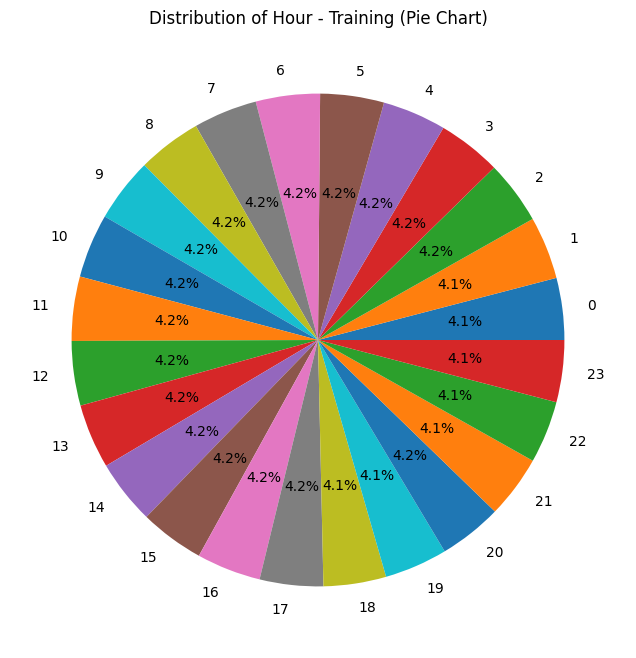

In [5]:
# survey times for each patient
raw_data.groupby(['p_num']).time.nunique()

raw_data['hour'] = pd.to_datetime(raw_data.time).dt.hour
plt.figure(figsize=(8, 8))
raw_data['hour'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Hour - Training (Pie Chart)')
plt.ylabel('')
plt.show()

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

Patients have the same amount of surveys, one every 5 minutes for the whole 24 hours. The difference in data amounts to the wearing time in days.

/tmp/ipykernel_17/2215116534.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_data['hour'] = pd.to_datetime(raw_data.time).dt.hour


<Axes: xlabel='p_num', ylabel='diff'>

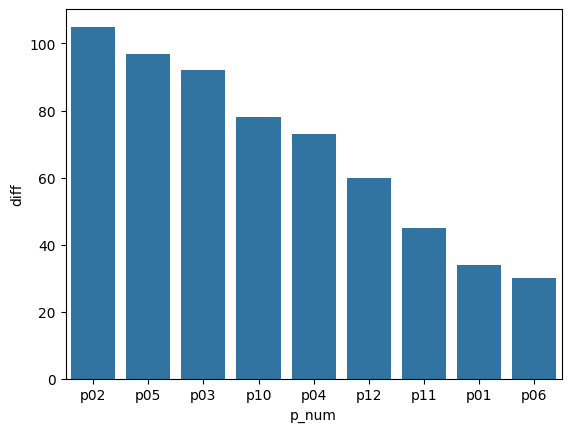

In [6]:
# Difference from the most and the least measured hours between patients (hour survey delta)

# cast the time column to datetime and extract the hour on a "hour" column
raw_data['hour'] = pd.to_datetime(raw_data.time).dt.hour

# group by patient and hour, to get all time counts
time_counts = raw_data.groupby(['p_num', 'hour']).p_num.count()

# get maximum and minimum number of surveys (hour) of each patient
patient_minmax = time_counts.groupby(['p_num']).aggregate(['max', 'min'])

# calculate diff
patient_minmax['diff'] = patient_minmax['max'] - patient_minmax['min']

# sort
patient_minmax = patient_minmax.sort_values(by='diff', ascending=False)

sns.barplot(y=patient_minmax['diff'], x=patient_minmax.index)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

Patients with more data have increased missing surveys.

Why patient 5 has high delta with low data numerosity?

/tmp/ipykernel_17/2543732925.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_counts_df['hour'] = pd.to_datetime(time_counts_df.index).hour


<Axes: xlabel='hour', ylabel='count'>

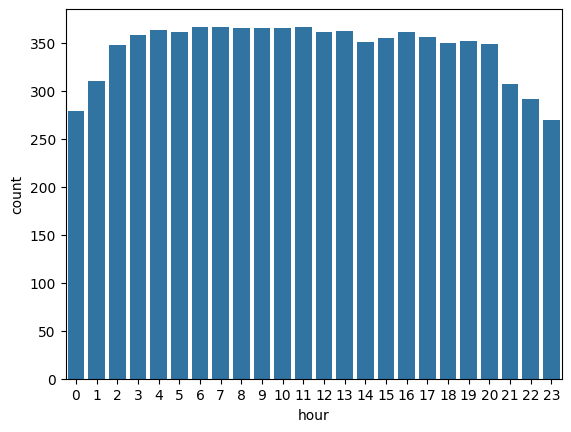

In [7]:
# Hour distribution of patient 5 surveys (has high hour survey delta, but low datapoint numerosity)

# filter by patient 1
p05_X = raw_data.loc[raw_data.p_num == 'p05']
# get all time counts
time_counts = p05_X.time.value_counts()

time_counts_df = pd.DataFrame(time_counts)

# cast the time column to datetime and extract the hour on a "hour" column
time_counts_df['hour'] = pd.to_datetime(time_counts_df.index).hour

# group by hour
time_counts_df_grouped = time_counts_df.groupby('hour').sum()

# sort
time_counts_df_grouped = time_counts_df_grouped.sort_values(by='count', ascending=False)

sns.barplot(y=time_counts_df_grouped['count'], x=time_counts_df_grouped.index )

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

There is, more or less, the same amount of data for each hour. Patient 5 probably wore the smartwatch wrong on some nights.

In [8]:
# check if patients have consistent missing columns
patients = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12']
for patient_id in patients:
    patient_X = raw_data.loc[raw_data.p_num == patient_id]
    cols_with_missing = len([col for col in raw_data.columns if raw_data[col].isnull().any])
    print("{} columns with missing data: {}".format(patient_id, cols_with_missing))


p01 columns with missing data: 508
p02 columns with missing data: 508
p03 columns with missing data: 508
p04 columns with missing data: 508
p05 columns with missing data: 508
p06 columns with missing data: 508
p10 columns with missing data: 508
p11 columns with missing data: 508
p12 columns with missing data: 508


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

Provided that we have data points every 5 minutes, and on each column there are missing data, we can conclude that data collection times are not consistent on the same patient.

There are 0 duplicated rows in the train data frame.


<Axes: >

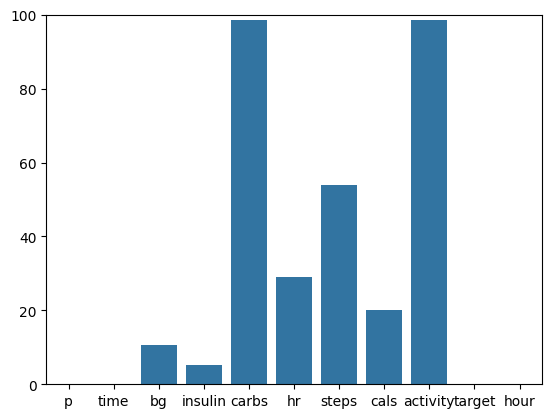

In [9]:
# count duplicated rows
print(f"There are {sum(raw_data.duplicated())} duplicated rows in the train data frame.")

# count rows
row_count = raw_data.shape[0]

# get a serie with missing value columns and count
features_with_missing_values = [col for col in raw_data.columns if raw_data[col].isnull().any]
missing_values_counts = raw_data[features_with_missing_values].isnull().sum()

# group by metric
missing_counts_grouped_by_metrics = {}
for key, value in missing_values_counts.items():
     metric = key.split("_")[0]
     missing_counts_grouped_by_metrics[metric] = (missing_counts_grouped_by_metrics.get(metric) or 0) + value

# convert to key-value list
keys = list(missing_counts_grouped_by_metrics.keys())
vals = list(missing_counts_grouped_by_metrics.values())

# convert values in percentage
vals = [(i * 100 / (row_count * 72)) for i in vals]

# set the plot max to 100, for accurate percentage representations
plt.ylim(0, 100)
sns.barplot(x=keys, y=vals)

/tmp/ipykernel_17/1639037430.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
/tmp/ipykernel_17/1639037430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
/tmp/ipykernel_17/1639037430.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hour', y='count', hue='p_num', data=grouped, ci=None)


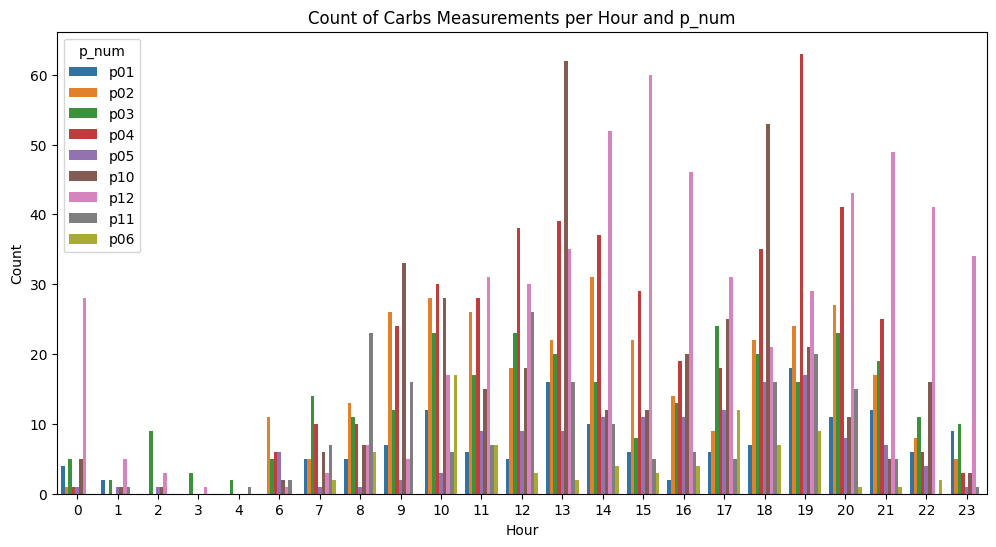

In [10]:
# check for time patterns on carbs surveys
carbs_X = raw_data.loc[raw_data['carbs_0_00'].notnull()]
carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
carbs_X = carbs_X[['p_num','carbs_0_00', 'hour']]

grouped = carbs_X.groupby(['p_num', 'hour']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', hue='p_num', data=grouped, ci=None)

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Carbs Measurements per Hour and p_num')
plt.legend(title='p_num')
plt.show()

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

carbs and activity have a great deal of empty data, but the distribution of the data we have is on the whole day.

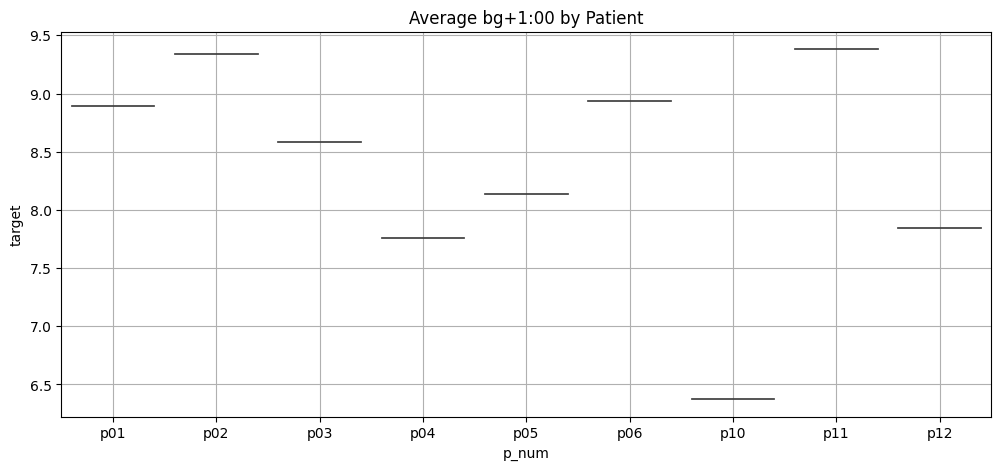

In [11]:
# Aggregate data by patient and plot the distribution
df_patient_avg = raw_data.groupby('p_num')['target'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.violinplot(data=df_patient_avg, x='p_num', y='target')
plt.title('Average bg+1:00 by Patient')
plt.grid(True)
plt.show()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Feature Engineering</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

Feature importance analysis has shown that the prediction is influences only by data from the past 45 mins / 1 hour.<br>
We can seize this opportunity to increase our dataset size by 6 times by changing the problem statement.

In [12]:
time_series = {
    '0': ['_0_55', '_0_50', '_0_45', '_0_40', '_0_35', '_0_30', '_0_25', '_0_20', '_0_15', '_0_10', '_0_05', '_0_00'],
    '1': ['_1_55', '_1_50', '_1_45', '_1_40', '_1_35', '_1_30', '_1_25', '_1_20', '_1_15', '_1_10', '_1_05', '_1_00'],
    '2': ['_2_55', '_2_50', '_2_45', '_2_40', '_2_35', '_2_30', '_2_25', '_2_20', '_2_15', '_2_10', '_2_05', '_2_00'],
    '3': ['_3_55', '_3_50', '_3_45', '_3_40', '_3_35', '_3_30', '_3_25', '_3_20', '_3_15', '_3_10', '_3_05', '_3_00'],
    '4': ['_4_55', '_4_50', '_4_45', '_4_40', '_4_35', '_4_30', '_4_25', '_4_20', '_4_15', '_4_10', '_4_05', '_4_00'],
    '5': ['_5_55', '_5_50', '_5_45', '_5_40', '_5_35', '_5_30', '_5_25', '_5_20', '_5_15', '_5_10', '_5_05', '_5_00']
}

def extract_sub_row(row, time_serie_suffixes, target_column, time_delta):
    
    # transform the row into a dictionary
    row_dict = row.to_dict()
    
    # create subrow object
    sub_row = {}
    
    # add patient number
    sub_row['p_num'] = row['p_num']
    
    # set the real time, by subtracting the delta from the time column
    sub_row['time'] = pd.to_datetime(row['time'], format='%H:%M:%S') - pd.Timedelta(hours=time_delta)

    # set the new target
    sub_row['target'] = row[target_column]
    
    # add columns containing the provided time series suffix list
    for key, value in row_dict.items():
        
        # check if the column contains one of the time series suffixes
        for index, suffix in enumerate(time_serie_suffixes):
            
            if suffix in key:
                # get metric name from key(bg_X_XX)
                metric_name = key.split('_')[0]
                
                # generate new column name
                new_column_name = f'{metric_name}_{str(index)}'
                
                # add column to the row
                sub_row[new_column_name] = value
                
    return sub_row
            
def split_data(df):
    """
    Split a row with 6 hours of data into 6 rows with 1 hour of data
    :param df:
    :return:
    """    
    rows = []
    
    # for each row in the dataset
    for idx, row in df.iterrows():
        # extract 6 one hour rows
        sub_row_0 = extract_sub_row(row, time_series['0'], 'target', 0)
        rows.append(sub_row_0)
        for i in range(1,6):
            target_column = f'bg_{str(i - 1)}_00'
            sub_row = extract_sub_row(row, time_series[str(i)], target_column, i)
            rows.append(sub_row)
            
    return pd.DataFrame(rows).sort_values(by=['p_num', 'time']).reset_index(drop=True)

def drop_prediction_columns(df):
    """
    Drops all the columns with data older than one hour
    :param df:
    :return:
    """
    cols_to_drop = []
    for column in df.columns:
        # rename first hour data columns
        for idx, suffix in enumerate(time_series['0']):
            if suffix in column:
                # get metric name from key(bg_X_XX)
                metric_name = column.split('_')[0]
                # generate new column name
                new_column_name = f'{metric_name}_{str(idx)}'
                # add new column
                df[new_column_name] = df[column]
                # remove old column
                cols_to_drop.append(column)
                continue
            
        for i in range(1,6):
            if any(time_serie_suffix in column for time_serie_suffix in time_series[str(i)]):
                cols_to_drop.append(column)
    df.drop(cols_to_drop,axis=1,inplace=True)

In [13]:
mesas_cols=['bg', 'insulin','steps','hr','cals']
divisible_cols=['bg','hr']

def create_features(df):
    # Generate mean, std and zscore of latest value
    for col in mesas_cols:
        # calculate mean
        df[f'mean_patient_{col}_11'] = df.groupby(['p_num'])[f"{col}_11"].transform('mean')
        # calculate standard deviation
        df[f'std_patient_{col}_11'] = df.groupby(['p_num'])[f"{col}_11"].transform('std')
        # z-score normalization
        df[f'norm_patient_{col}_11'] = (df[f'{col}_11'] - df[f'mean_patient_{col}_11']) / df[f'std_patient_{col}_11']
        

    # Pairwise Feature Interactions on 3 latest values
    for i in range(len(mesas_cols)):
        for j in range(i + 1, len(mesas_cols)):
            for k in [1,2,3]:
                time_index = 12 - k
                # bg_11_plus_hr_11 = bg_11 + hr_11
                df[f"{mesas_cols[i]}_{time_index}_plus_{mesas_cols[j]}_{time_index}"] = df[f"{mesas_cols[i]}_{time_index}"] + df[f"{mesas_cols[j]}_{time_index}"]
                # bg_11_minus_hr_11 = bg_11 - hr_11
                df[f"{mesas_cols[i]}_{time_index}_minus_{mesas_cols[j]}_{time_index}"] = df[f"{mesas_cols[i]}_{time_index}"] - df[f"{mesas_cols[j]}_{time_index}"]
                # bg_11_multiplied_hr_11 = bg_11 * hr_11
                df[f"{mesas_cols[i]}_{time_index}_multiplied_{mesas_cols[j]}_{time_index}"] = df[f"{mesas_cols[i]}_{time_index}"] * df[f"{mesas_cols[j]}_{time_index}"]
                # bg_11_divided_hr_11 = bg_11 / hr_11 + 1e-15
                df[f"{mesas_cols[i]}_{time_index}_divided_{mesas_cols[j]}_{time_index}"] = df[f"{mesas_cols[i]}_{time_index}"] / (df[f"{mesas_cols[j]}_{time_index}"] + 1e-15)
                
            # bg_11_minus_hr_11_minus_bg_10_minus_hr_10 = bg_11_minus_hr_11 - bg_10_minus_hr_10
            df[f"{mesas_cols[i]}_11_minus_{mesas_cols[j]}_11_minus_{mesas_cols[i]}_10_minus_{mesas_cols[j]}_10"]=\
            df[f"{mesas_cols[i]}_11_minus_{mesas_cols[j]}_11"] - df[f"{mesas_cols[i]}_10_minus_{mesas_cols[j]}_10"]
    
    # compute differences and combinations of all values
    for col in mesas_cols:
        for i in range(1,12):
            # bg_11_minus_bg_10 = bg_11 - bg_10
            df[f"{col}_{i}_minus_{col}_{i-1}"]=df[f"{col}_{i}"] - df[f"{col}_{i-1}"]
            
            # bg_11_plus_bg_10 = bg_11 + bg_10
            df[f'{col}_{i}_plus_{col}_{i-1}'] = df[f'{col}_{i}'] + df[f'{col}_{i-1}']
        
            # bg_11_multiplied_bg_10 = bg_11 * bg_10
            df[f'{col}_{i}_multiplied_{col}_{i-1}'] = df[f'{col}_{i}'] * df[f'{col}_{i-1}']
            
    # compute division only on worthy columns
    for col in divisible_cols:
        for i in range(1,12): 
            # bg_11_divided_bg_10 = bg_11 / bg_10
            df[f'{col}_{i}_divided_{col}_{i-1}'] = df[f'{col}_{i}'] / df[f'{col}_{i-1}']

In [14]:
activity_dictionary = {'None': 0, 'Yoga': 1, 'Walking': 2, 'Walk': 2, 'Dancing': 3, 'Zumba': 4,
                       'Strength training': 5,
                       'Weights': 6, 'Aerobic Workout': 7, 'Workout': 8, 'HIIT': 9, 'Run': 10, 'Running': 10,
                       'Bike': 11, 'Outdoor Bike': 11, 'Stairclimber': 12, 'Spinning': 13, 'Swim': 14,
                       'Swimming': 14,
                       'Tennis': 15, 'Indoor climbing': 16, 'Hike': 17, 'Sport': 18}

# Create a dictionary that maps each patient to a number
partecipants_dictionary = {'p01': 1, 'p02': 2, 'p03': 3, 'p04': 4, 'p05': 5, 'p06': 6, 'p07': 7, 'p08': 8, 'p09': 9,
                           'p10': 10, 'p11': 11, 'p12': 12, 'p13': 13, 'p14': 14, 'p15': 15, 'p16': 16, 'p17': 17,
                           'p18': 18, 'p19': 19, 'p20': 20, 'p21': 21, 'p22': 22, 'p23': 23, 'p24': 24}

def drop_features(X):
    # drop carbs
    X.drop([c for c in X.columns if 'carbs' in c],axis=1,inplace=True)


def transform_time(X):
    # extract a hour and minute series
    time_col = pd.to_datetime(X['time'], format='%H:%M:%S')
    hours = time_col.dt.hour
    minutes = time_col.dt.minute

    # create a hour sin and cos wave
    X['hour_sin'] = np.sin(2 * np.pi * hours / 24)
    X['hour_cos'] = np.cos(2 * np.pi * hours / 24)
    # create a minute sin and cos wave
    X['minute_sin'] = np.sin(2 * np.pi * minutes / 60)
    X['minute_cos'] = np.cos(2 * np.pi * minutes / 60)
    # remove time
    X.drop(['time'], axis=1, inplace=True)


def encode_and_0fill(X):
    steps_columns = []
    activity_columns = []
    carbs_columns = []
    cals_columns = []

    for column in X.columns:
        # if the column is a metric with a survey time
        if 'steps_' in column:
            steps_columns.append(column)
        if 'activity_' in column:
            activity_columns.append(column)
        if 'carbs_' in column:
            carbs_columns.append(column)
        if 'cals_' in column:
            cals_columns.append(column)

    X[activity_columns] = X[activity_columns].fillna('None')  # assume no activity when empty

    # apply static encoding for activities
    for col in activity_columns:
        # Assign values based on the dictionary and set -1 for empty values
        X[col] = X[col].apply(lambda x: activity_dictionary.get(x, -1) if x != '' else -1)

    # apply static encoding for patients
    # Assign values based on the dictionary and set -1 for empty values
    X['p_num'] = X['p_num'].apply(lambda x: partecipants_dictionary.get(x, -1) if x != '' else -1)

    X[steps_columns] = X[steps_columns].fillna(0)  # assume 0 steps when empty
    X[carbs_columns] = X[carbs_columns].fillna(0)  # assume 0 carbohydrate intake when empty
    X[cals_columns] = X[cals_columns].fillna(0)  # assume 0 calories burned when empty


def fill_time_series(X):
    # create a dictionary of metrics and their corresponding columns
    metric_columns = {}
    for column in X.columns:
        if '_' in column:
            # get the metric name
            metric_name = column.split("_")[0]
            # get the array of existing columns with the same metrics (or create it) and add the current column
            metric_columns_names = metric_columns.get(metric_name) or []
            metric_columns_names.append(column)
            # save the new array on the dictionary
            metric_columns[metric_name] = metric_columns_names

    # iterate metrics
    for key, value in metric_columns.items():
        # Sort the metric columns in descending order
        columns = sorted(value, key=lambda x: '_'.join(x.split('_')[1:]), reverse=True)

        # Fill missing values using backfill (and forward fill if the latest values are empty)
        X[columns] = X[columns].bfill()
        X[columns] = X[columns].ffill()

def delete_strong_correlated_columns(X):
    # reduce  overfitting, strong correlations between nearest timestep features
    X.drop([f'bg_{i}'for i in range(12) if i % 2 != 0], axis=1, inplace=True)

def preprocess_data(X):
    #drop_features(X)
    encode_and_0fill(X)
    fill_time_series(X)
    drop_prediction_columns(X)
    #create_features(X)
    transform_time(X)
    #delete_strong_correlated_columns(X)

def preprocess_train_data(X):
    #drop_features(X)
    encode_and_0fill(X)
    fill_time_series(X)
    X = split_data(X)
    #create_features(X)
    transform_time(X)
    #delete_strong_correlated_columns(X)
    return X

In [15]:
X['target'] = y
X = preprocess_train_data(X)
X.to_csv('preprocessed_train.csv')
y = X['target']
X = X.drop(['target'], axis=1)

In [16]:
print('total columns: ', len(X.columns.values))

features_with_missing_values = [col for col in X.columns if X[col].isnull().any()]

print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print('--- Percentage of Missing Values ---')
print(100*X[features_with_missing_values].isnull().sum() / X.shape[0])

categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
print('number of categorical columns: ', len(categorical_cols))
print(categorical_cols)

total columns:  89
number of columns with missing values:  0
[]
--- Percentage of Missing Values ---
Series([], dtype: float64)
number of categorical columns:  0
[]


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

Dataframe successfully cleaned up, no need for further pipelines.

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Train model</p>

In [17]:
# instantiate data pipeline
from src.pipelines.empty_dt_pipeline import EmptyDTPipeline
pipeline = EmptyDTPipeline(X)

# pick a model, and a trainer
model_type = XGBRegressorWrapper()
trainer = AccurateCrossTrainer(pipeline, model_type, metric=AccuracyMetric.RMSE)

# optimizing parameters worsens performance for this dataset
optimized_params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.03,
            'n_jobs': -1,
}

# Train model
_, boost_rounds, _ = trainer.validate_model(X, y, log_level=0, params=optimized_params)

{}


          feats  importance
0         bg_11   48.828106
1          bg_8    2.735610
2         p_num    2.505720
3    activity_6    1.598672
4          bg_9    1.579750
5          bg_5    1.575199
6      hour_cos    1.474652
7      hour_sin    1.335607
8     insulin_4    1.325221
9         hr_11    1.322038
10   activity_5    1.236726
11   activity_4    1.136106
12    insulin_7    1.133316
13    insulin_9    1.126596
14    insulin_3    1.106666
15    insulin_6    1.093850
16  activity_11    1.093254
17    insulin_5    1.076650
18    insulin_2    1.059452
19   insulin_11    1.033456
20    insulin_8    0.997276
21      cals_11    0.981384
22         bg_2    0.965119
23     carbs_11    0.965107
24    insulin_0    0.947405
25    insulin_1    0.933604
26        bg_10    0.932658
27   insulin_10    0.917236
28      carbs_2    0.882851
29   activity_1    0.878651
30   activity_3    0.861064
31     steps_11    0.854093
32         bg_6    0.844851
33        hr_10    0.815360
34      carbs_1    0

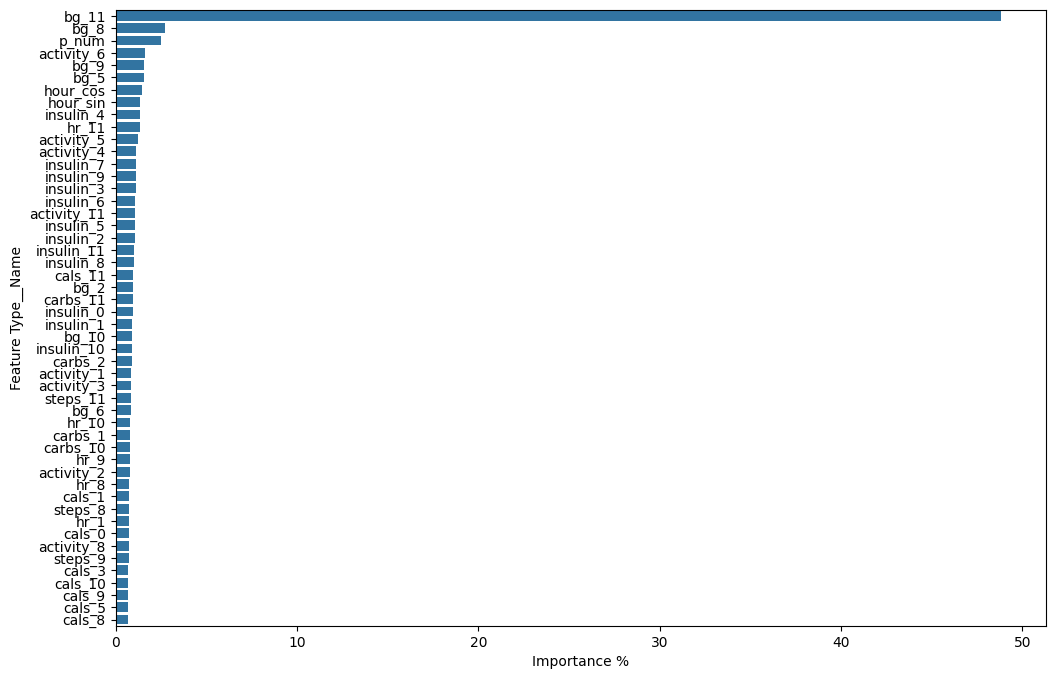

In [18]:
trainer.show_feature_importance(X)

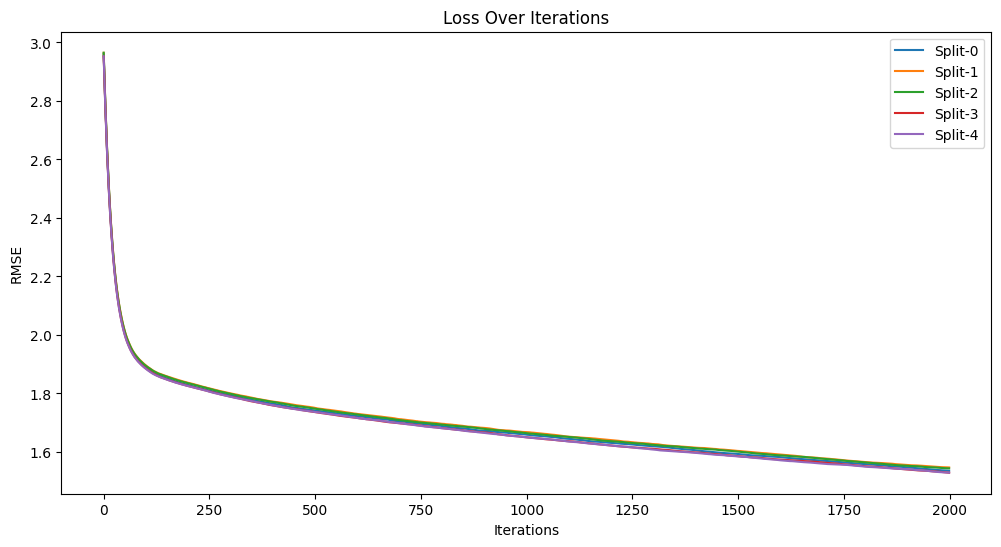

In [19]:
trainer.show_loss()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Train complete model on all data</p>

In [20]:
# fit complete_model on all data from the training data
complete_model = trainer.train_model(X, y, iterations=boost_rounds, params=optimized_params)

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Make predictions on the competition data, and generate submission</p>

In [21]:
# Load the data
test_data_path = '/kaggle/input/brist1d/test.csv'
test_data = pd.read_csv(test_data_path, index_col='id')
test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
preprocess_data(test_data)

# make predictions which we will submit. 
test_preds = complete_model.predict(test_data)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_data.index,
                       'bg+1:00': test_preds})
output.to_csv('submission.csv', index=False)

/tmp/ipykernel_17/2473841178.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[column]
